In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint # type: ignore #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model # type: ignore #tải mô hình
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore

#các lớp để xây dựng mô hình
from keras.models import Sequential # type: ignore #đầu vào
from keras.layers import LSTM # type: ignore #học phụ thuộc
from keras.layers import Dropout # type: ignore #tránh học tủ
from keras.layers import Dense # type: ignore #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score  # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error  # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, f1_score  # Đo % sai số tuyệt đối trung bình

from pymongo import MongoClient

In [2]:

# Kết nối đến MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['metadata']  
collection = db['VRE']  

# Chuyển dữ liệu thành DataFrame
df = pd.DataFrame(list(collection.find({}, {"_id": 0})))
df


,Ngay,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
0,2017-11-07,32.15,40.55,0,0,414939570,16861296817200,40.55,40.55,40.55,0.00,0.00
1,2017-11-08,32.15,40.55,0,0,0,0,40.55,40.55,40.55,0.00,0.00
2,2017-11-17,35.36,44.60,10742380,478064000000,530010,23543445000,44.00,45.50,43.30,0.60,1.36
3,2017-11-20,37.82,47.70,3176670,149945000000,150000,7080000000,45.60,47.70,45.00,3.10,6.95
4,2017-11-22,40.91,51.60,7455670,389095000000,0,0,51.50,54.00,50.40,0.60,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...
1776,2024-12-17,17.15,17.15,5731600,98438000000,0,0,17.30,17.35,17.10,-0.15,-0.87
1777,2024-12-13,17.35,17.35,3566800,61732000000,1300000,21125000000,17.30,17.40,17.20,0.05,0.29
1778,2024-12-18,17.10,17.10,4496000,77042000000,1800000,32670000000,17.15,17.20,17.10,-0.05,-0.29
1779,2024-12-19,17.05,17.05,6408800,109373000000,0,0,17.05,17.25,16.95,-0.05,-0.29


In [3]:
# Kiểm tra dữ liệu
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ngay               1781 non-null   object 
 1   GiaDieuChinh       1781 non-null   float64
 2   GiaDongCua         1781 non-null   float64
 3   KhoiLuongKhopLenh  1781 non-null   int64  
 4   GiaTriKhopLenh     1781 non-null   int64  
 5   KLThoaThuan        1781 non-null   int64  
 6   GtThoaThuan        1781 non-null   int64  
 7   GiaMoCua           1781 non-null   float64
 8   GiaCaoNhat         1781 non-null   float64
 9   GiaThapNhat        1781 non-null   float64
 10  ThayDoi_GiaTri     1781 non-null   float64
 11  ThayDoi_PhanTram   1781 non-null   float64
dtypes: float64(7), int64(4), object(1)
memory usage: 167.1+ KB


,GiaDieuChinh,GiaDongCua,KhoiLuongKhopLenh,GiaTriKhopLenh,KLThoaThuan,GtThoaThuan,GiaMoCua,GiaCaoNhat,GiaThapNhat,ThayDoi_GiaTri,ThayDoi_PhanTram
count,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000
mean,29.368860,30.720887,4.253535e+06,1.230833e+11,7.971469e+05,2.941009e+10,30.735373,31.204155,30.278074,-0.002673,0.003464
std,5.310181,7.538048,3.672416e+06,1.014855e+11,1.031765e+07,4.207755e+11,7.554911,7.704975,7.410834,0.751170,2.308886
min,16.800000,16.800000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,17.000000,17.150000,16.700000,-3.800000,-7.120000
25%,26.500000,26.500000,1.700630e+06,5.312500e+10,0.000000e+00,0.000000e+00,26.500000,27.000000,26.100000,-0.350000,-1.120000
50%,29.190000,29.350000,3.192200e+06,9.167700e+10,0.000000e+00,0.000000e+00,29.350000,29.750000,28.850000,0.000000,0.000000
75%,32.930000,34.150000,5.645600e+06,1.637920e+11,3.600000e+05,1.139250e+10,34.200000,34.600000,33.850000,0.300000,1.060000
max,48.370000,61.000000,3.458230e+07,9.274040e+11,4.149396e+08,1.686130e+13,60.100000,61.500000,58.500000,6.750000,19.970000


In [4]:
# Xử lý thời gian và sắp xếp dữ liệu
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%Y-%m-%d')
df = df.sort_values(by='Ngay')

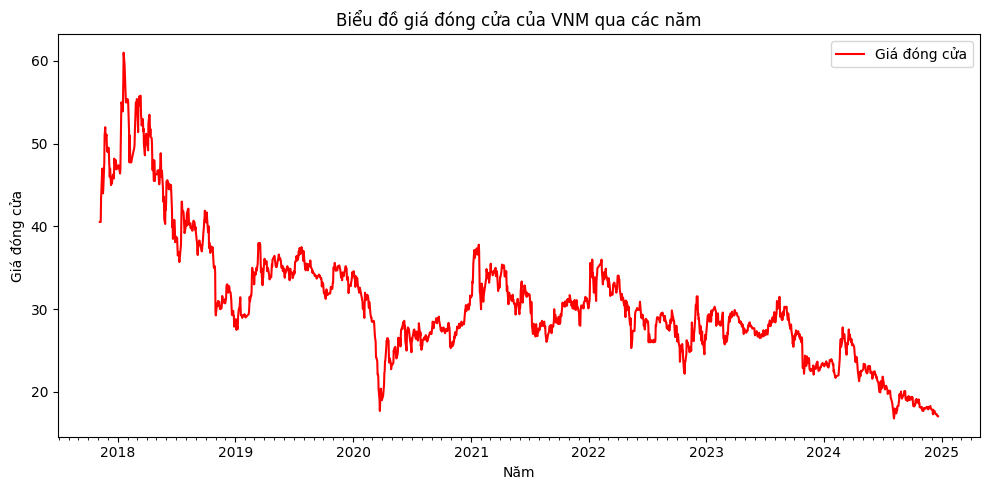

In [5]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Lấy thông tin năm từ cột "Ngày"
df['Nam'] = df['Ngay'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Ngay'], df['GiaDongCua'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VNM qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [6]:
# Chuyển đổi sang chỉ số thời gian
df1 = pd.DataFrame(df, columns=['Ngay', 'GiaDongCua'])
df1.index = df1['Ngay']
df1.drop('Ngay', axis=1, inplace=True)

In [7]:
df1

,GiaDongCua
Ngay,
2017-11-06,40.55
2017-11-07,40.55
2017-11-08,40.55
2017-11-09,40.55
2017-11-10,43.35
...,...
2024-12-16,17.30
2024-12-17,17.15
2024-12-18,17.10


In [8]:
# Chia tập dữ liệu
data = df1.values
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [9]:
data

array([[40.55],
       [40.55],
       [40.55],
       ...,
       [17.1 ],
       [17.05],
       [17.05]])

In [10]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [11]:
# Tạo cửa sổ thời gian cho tập train
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_train.append(sc_train[i, 0])  # Giá trị tiếp theo
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Tạo cửa sổ thời gian cho tập test
x_test, y_test = [], []
for i in range(50, len(test_data)):
    x_test.append(sc_train[i - 50:i, 0])  # 50 giá trị trước đó
    y_test.append(sc_train[i, 0])  # Giá trị tiếp theo
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/100


C:\Users\TRUONG\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: loss improved from inf to 0.20173, saving model to save_models/VRE_model.keras
22/22 - 5s - 209ms/step - loss: 0.2017 - val_loss: 0.1569
Epoch 2/100

Epoch 2: loss improved from 0.20173 to 0.11636, saving model to save_models/VRE_model.keras
22/22 - 1s - 47ms/step - loss: 0.1164 - val_loss: 0.0971
Epoch 3/100

Epoch 3: loss improved from 0.11636 to 0.09788, saving model to save_models/VRE_model.keras
22/22 - 1s - 46ms/step - loss: 0.0979 - val_loss: 0.0860
Epoch 4/100

Epoch 4: loss improved from 0.09788 to 0.08333, saving model to save_models/VRE_model.keras
22/22 - 1s - 45ms/step - loss: 0.0833 - val_loss: 0.0764
Epoch 5/100

Epoch 5: loss improved from 0.08333 to 0.07727, saving model to save_models/VRE_model.keras
22/22 - 1s - 46ms/step - loss: 0.0773 - val_loss: 0.0806
Epoch 6/100

Epoch 6: loss improved from 0.07727 to 0.07288, saving model to save_models/VRE_model.keras
22/22 - 1s - 46ms/step - loss: 0.0729 - val_loss: 0.0667
Epoch 7/100

Epoch 7: loss improved from 0.

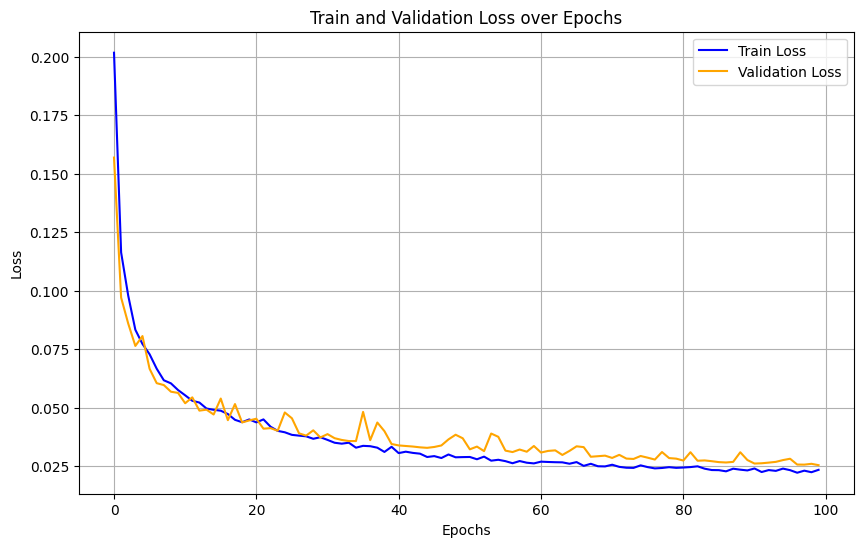

In [48]:
def build_model(input_shape):
    model = Sequential()
    
    # Giảm số đơn vị trong LSTM và tăng regularization
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True, 
                   kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=32, kernel_regularizer=l2(0.001)))
    
    # Tăng Dropout để giảm overfitting
    model.add(Dropout(0.3))
    
    # Lớp Dense để đưa ra kết quả dự đoán
    model.add(Dense(1))
    
    # Compile mô hình
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))
    return model

# Xây dựng mô hình
input_shape = (x_train.shape[1], x_train.shape[2])
model = build_model(input_shape)

# Đường dẫn lưu mô hình
save_model_path = "save_models/VRE_model.keras"

# Callbacks: ModelCheckpoint và EarlyStopping
callbacks = [
    ModelCheckpoint(save_model_path, monitor='loss', verbose=2, save_best_only=True, mode='auto'),
    EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=2)
]

# Huấn luyện mô hình và lưu kết quả vào history
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),  # Thêm tập validation
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=callbacks
)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')  # Thêm val_loss
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
save_model_path = "models/VRE_model.keras"
# Tải mô hình tốt nhất
final_model = load_model(save_model_path)

In [16]:
# Dự đoán trên tập train
y_train_predict = final_model.predict(x_train)
y_train_predict = sc.inverse_transform(y_train_predict)
y_train = sc.inverse_transform(y_train.reshape(-1, 1))

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


In [17]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[int(len(df) * 0.8):] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


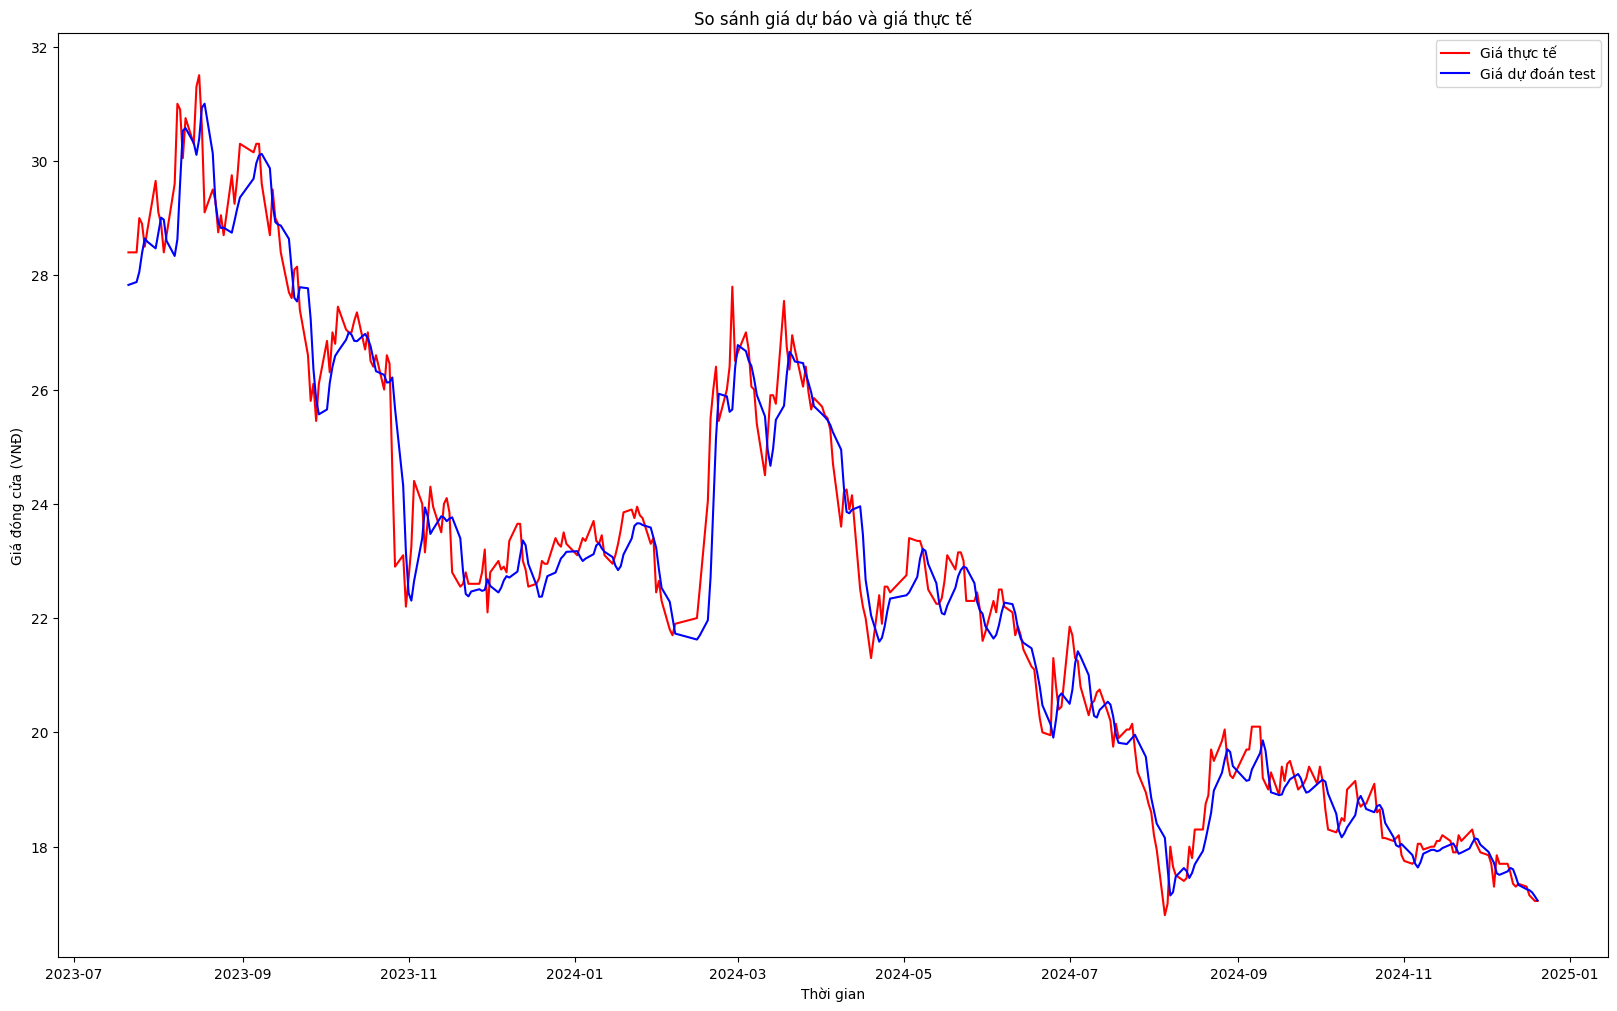

In [18]:
# Chọn dữ liệu cho test_data1
num_test_predictions = len(y_test_predict)
test_data1 = df.iloc[-num_test_predictions:].copy()
plt.figure(figsize=(20, 12))
if 'Ngay' in test_data1.columns:
    plt.plot(test_data1['Ngay'], test_data1['GiaDongCua'], label='Giá thực tế', color='red')
else:
    raise KeyError("Cột 'Ngày' không tồn tại trong test_data1.")

test_data1 = test_data1.copy()
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Ngay'], test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.title('So sánh giá dự báo và giá thực tế')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.legend()
plt.show()


In [53]:
print('--- Kết quả trên tập train ---')
# R2 score
print('Độ phù hợp tập train (R2):', r2_score(y_train, y_train_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập train:', mean_absolute_percentage_error(y_train, y_train_predict) * 100)

# RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
print('RMSE trên tập train (VNĐ):', rmse_train)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_train = np.max(y_train) - np.min(y_train)
accuracy_train = 1 - (rmse_train / range_y_train)
print('Độ chính xác trên tập train (%):', accuracy_train * 100)

# F1 Score (Chuyển thành bài toán phân loại)
error_threshold = 10  # Ngưỡng sai số
y_train_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
y_train_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_train, y_train_predict)]
f1_train = f1_score(y_train_class, y_train_pred_class)
print('F1 Score trên tập train:', f1_train)
print("----------------------------------------------------")

--- Kết quả trên tập train ---
Độ phù hợp tập train (R2): 0.974778470841221
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.7204882881353343
Phần trăm sai số tuyệt đối trung bình trên tập train: 2.2737995060052323
RMSE trên tập train (VNĐ): 1.0172614981964838
Độ chính xác trên tập train (%): 97.65066628592037
F1 Score trên tập train: 1.0
----------------------------------------------------


In [54]:
y_test = data[-len(y_test_predict):]

In [55]:
print('--- Kết quả trên tập test ---')
# R2 score
print('Độ phù hợp tập test (R2):', r2_score(y_test, y_test_predict))

# MAE
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

# MAPE
print('Phần trăm sai số tuyệt đối trung bình trên tập test:', mean_absolute_percentage_error(y_test, y_test_predict) * 100)

# RMSE
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
print('RMSE trên tập test (VNĐ):', rmse_test)

# Accuracy (dựa trên RMSE và biên độ giá trị thực tế)
range_y_test = np.max(y_test) - np.min(y_test)
accuracy_test = 1 - (rmse_test / range_y_test)
print('Độ chính xác trên tập test (%):', accuracy_test * 100)

# F1 Score (Chuyển thành bài toán phân loại)
y_test_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
y_test_pred_class = [1 if abs(y - yp) < error_threshold else 0 for y, yp in zip(y_test, y_test_predict)]
f1_test = f1_score(y_test_class, y_test_pred_class)
print('F1 Score trên tập test:', f1_test)
print("----------------------------------------------------")

--- Kết quả trên tập test ---
Độ phù hợp tập test (R2): 0.9227863822560762
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.8880966400231969
Phần trăm sai số tuyệt đối trung bình trên tập test: 4.167597117463078
RMSE trên tập test (VNĐ): 1.0308685285858434
Độ chính xác trên tập test (%): 92.98728892118474
F1 Score trên tập test: 1.0
----------------------------------------------------


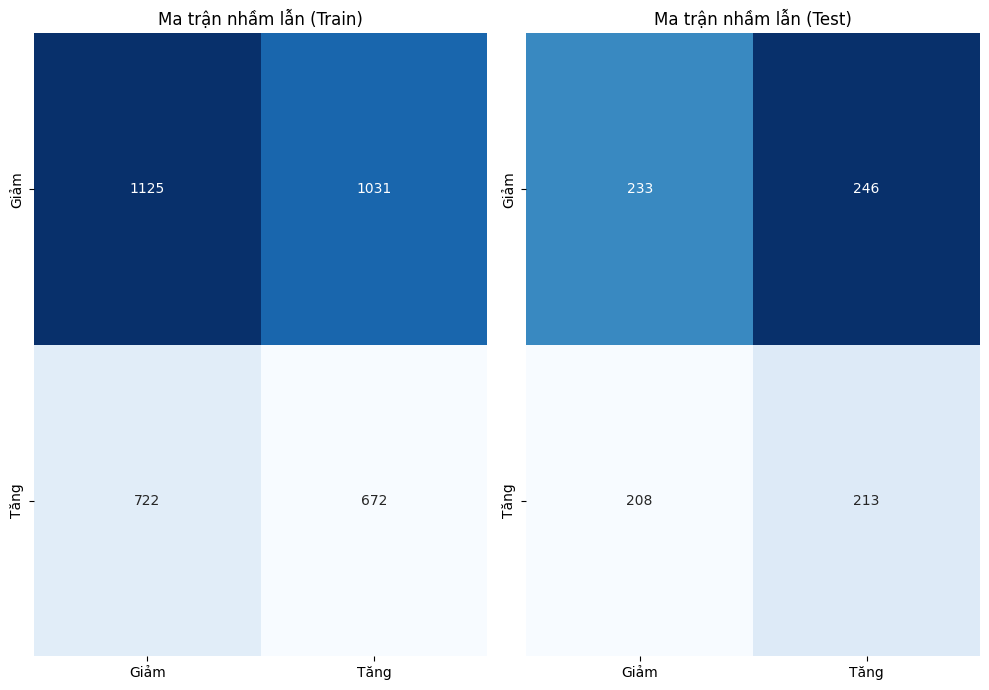

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_labels(data):
    return [1 if data[i] > data[i-1] else 0 for i in range(1, len(data))]

# Chuyển đổi giá trị thực tế và dự đoán thành nhãn phân loại
y_train_labels = create_labels(y_train)
y_train_predict_labels = create_labels(y_train_predict.flatten())

y_test_labels = create_labels(y_test)
y_test_predict_labels = create_labels(y_test_predict.flatten())

# Tạo ma trận nhầm lẫn cho tập train
cm_train = confusion_matrix(y_train_labels, y_train_predict_labels)
cm_test = confusion_matrix(y_test_labels, y_test_predict_labels)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(10, 7))

# Ma trận nhầm lẫn cho tập train
plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Train)")

# Ma trận nhầm lẫn cho tập test
plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Giảm", "Tăng"], yticklabels=["Giảm", "Tăng"])
plt.title("Ma trận nhầm lẫn (Test)")

plt.tight_layout()
plt.show()